In [1]:
from ROOT import TH1F, TFile, gROOT, gDirectory, TCanvas
import math
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


In [2]:
# Should we remake the Run 3 root files?
# (The reason for this is that we do not need to 
# remake the Run 3 root files to just make the figure with the scaling)
remakeRootFiles = False

# Should we remake the figure with the scales?
remakeFigure = False

In [3]:
# Function to rescale the cross-section from 7 TeV to 13 TeV
# Taken from milliq_mcgen/blob/master/oniaDirect/Atlas_7_TeV/makeOutput.py
# Made it work for float or numpy ptrans 
# and change the truncation to 25 GeV
def LHCBRescale(flag, ptrans):
    qt = ptrans.copy()
    if hasattr(qt , '__len__'):
        np.clip(qt, -1, 25, out=qt)
    else:
        qt = 25

    if flag == 1:   # upsilon 1S
        return 1.152 + 0.05074*qt - 0.0007649*qt*qt
    elif flag == 2: # upsilon 2S
        return 1.07 + 0.05387*qt - 0.001126*qt*qt
    elif flag == 3: # upsilon 3S
        return 1.192 + 0.0516*qt - 0.001176*qt*qt

    print("Illegal call to LHCBRescale")
    return 1.0

In [4]:
inFiles   = ["ups1S_combined.root",      "ups2S_combined.root",      "ups3S_combined.root"]
outFiles  = ["ups1S_combined_run3.root", "ups2S_combined_run3.root", "ups3S_combined_run3.root"]
outScales = [" ", " ", " "]
bC        = [" ", ' ', ' ']
for i in [0,1,2]: 
    
    fin = TFile(inFiles[i])
    # Get the contents of the histograms and the bin edges and centers
    # Remove underflow
    central    = np.array(gROOT.FindObject("central"))[1:]
    up         = np.array(gROOT.FindObject("up"))[1:]
    down       = np.array(gROOT.FindObject("down"))[1:]
    bins       = np.array(gROOT.FindObject("central").GetXaxis().GetXbins())
    binsCenter = 0.5 * (bins[:-1]+bins[1:])

    # the scale factor to go from 13 to 13.6 extrapolated from the scale factor to go from 7 to 13
    scale        = 1 + ((LHCBRescale(i+1, binsCenter) - 1) * (13.6-13)/(13-7))
    outScales[i] =  scale
    bC[i] = binsCenter
    # add the overflow bin
    scale = np.append(scale, scale[-1])
    
    # if we do not want to remake the root file we are done
    if not remakeRootFiles:
        continue
    
    # scale the arrays
    central = scale*central
    up      = scale*up
    down    = scale*down
    
    # we need this later
    y1 = gROOT.FindObject("central")
    
    # open a new file
    newfile = TFile(outFiles[i], "RECREATE")
    
    # The central, up, and down output histograms
    hcen  = y1.Clone()
    hup   = y1.Clone()
    hdown = y1.Clone()
    hcen.SetName("central")
    hcen.SetTitle("central")
    hup.SetName("up")
    hup.SetTitle("up")
    hdown.SetName("down")
    hdown.SetTitle("down")
    hcen.SetYTitle("BR(mumu) * dsigma/dpt (nb/GeV) for abs(y)<1.2")
    hup.SetYTitle("BR(mumu) * dsigma/dpt (nb/GeV) for abs(y)<1.2")
    hdown.SetYTitle("BR(mumu) * dsigma/dpt (nb/GeV) for abs(y)<1.2")
    
    # zero everything out
    hcen.Reset("ICESM")
    hup.Reset("ICESM")
    hdown.Reset("ICESM")
    
    # fill the histograms
    for i in range(len(central)):
        j = i + 1
        hcen.SetBinContent(j, central[i])
        hup.SetBinContent(j, up[i])
        hdown.SetBinContent(j, down[i])
        hcen.SetBinError(j, 0)
        hup.SetBinError(j, 0)
        hdown.SetBinError(j, 0)
    
    # Write and close files
    newfile.Write()
    newfile.Close()
    fin.Close()

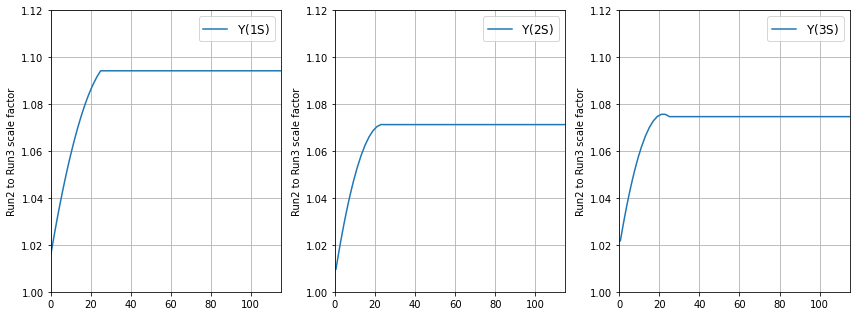

In [5]:
figure = plt.figure(figsize=(12, 4.5))
ups = [r'$\Upsilon$(1S)', r'$\Upsilon$(2S)', r'$\Upsilon$(3S)']
ipl = 0
for s,l,b in zip(outScales, ups, bC):
    ipl = ipl+1
    ax = plt.subplot(130+ipl)
    ax.plot(b, s, label=l)
    ax.grid()
    ax.legend(fontsize='large')
    ax.set_ylim(1,1.12)
    ax.set_xlim(0,b[-1])
    ax.set_ylabel('Run2 to Run3 scale factor')
    
plt.tight_layout()
if remakeFigure:
    figure.savefig("Run2_to_Run3_scale.pdf")